# OTA Room Price Analysis

### Execute the cell below once to turn off debugging

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

## Initialize OTA Scraper Class
Required to extract the data from the Wrangler

In [2]:
import sys
sys.path.insert(1, '../../lib/wrangler')
import otaWebScraper as otaws
import clean as clean
import datetime

dataDirPath="../../data/hospitality/bookings/scraper/"

if debug:
    import importlib
    otaws = importlib.reload(otaws)
    clean = importlib.reload(clean)
    
clsScraper = otaws.OTAWebScraper()
clsCleaner = clean.DataClensing()

All packages in OTAWebScraper loaded successfully!
All packages in DataClensing loaded successfully!
All packages in OTAWebScraper loaded successfully!
All packages in DataClensing loaded successfully!


## Load the data

In [3]:
#dirPath = _current_search_data_dir
dirPath = dataDirPath+"rates/2022-9-6-9-30/"
removed_files = clsScraper.remove_empty_files(dirPath)
if len(removed_files) > 0:
    print("%d files removed" %len(removed_files))
kwargs = {"columns" : ["search_datetime",
#                     "checkin_date",
                     "propery_name",
                     "room_type",
                     "room_rate",
                     "review_score",
                     "destination_id",
                     "other"]}

rates_df = clsScraper.read_folder_csv_to_df(dirPath, **kwargs)

In [4]:
''' drop duplicate rows '''
import pandas as pd

_distinct_df = pd.DataFrame()

print(rates_df.shape)
_distinct_df = clsCleaner.drop_duplicates(rates_df)
print(_distinct_df.shape)

(5098, 7)
(2177, 7)


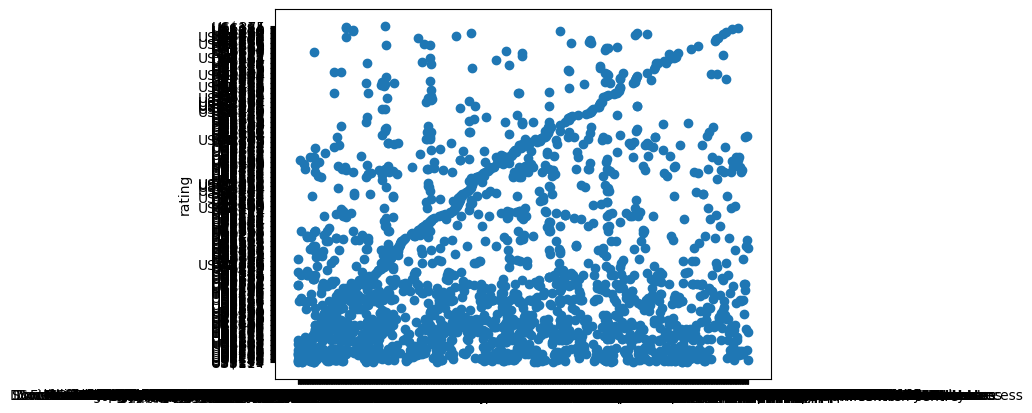

In [8]:
import matplotlib.pyplot as plt

plt.scatter(_distinct_df['destination_id'],_distinct_df['room_rate'])
plt.ylabel('rating')
plt.show()